In [1]:
import pandas as pd
# Load files
errors_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_errors.csv')
failures_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_failures.csv')
machines_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_machines.csv')
maint_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_maint.csv')
telemetry_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_telemetry.csv')

In [2]:
#Convert datetime columns to datetime objects
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'])

滚动窗口提取机器数据的时间特征(24H均值)

In [3]:
df = telemetry_df

# 保留原始的 datetime 列以备后用
original_datetime = df['datetime']
original_machineID = df['machineID']

# 从 DataFrame 中移除 datetime 列
df_numeric = df.drop(columns=['datetime'])

# 对于每24行数据计算均值
rolling_df = df_numeric.rolling(window=24, min_periods=1, closed='both').mean()

# # 计算滚动窗口的最大值
# rolling_max = df_numeric.rolling(window=24, min_periods=1, closed='both').max()
# rolling_max['datetime'] = original_datetime
# rolling_max['machineID'] = original_machineID


# # 计算滚动窗口的最小值
# rolling_min = df_numeric.rolling(window=24, min_periods=1, closed='both').min()
# rolling_min['datetime'] = original_datetime
# rolling_min['machineID'] = original_machineID


# 计算滚动窗口的标准差
# rolling_std = df_numeric.rolling(window=24, min_periods=1, closed='both').std()
# rolling_std['datetime'] = original_datetime
# rolling_std['machineID'] = original_machineID

# 将原始的 datetime 列添加回去
rolling_df['datetime'] = original_datetime
rolling_df['machineID'] = original_machineID

# # 将计算出的统计数据合并到 rolling_means 中
# rolling_df = rolling_df.merge(rolling_max, on=['datetime', 'machineID'], suffixes=('', '_max'))
# rolling_df = rolling_df.merge(rolling_min, on=['datetime', 'machineID'], suffixes=('', '_min'))
# rolling_df = rolling_df.merge(rolling_std, on=['datetime', 'machineID'], suffixes=('', '_std'))


In [4]:
rolling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   machineID  876100 non-null  int64         
 1   volt       876100 non-null  float64       
 2   rotate     876100 non-null  float64       
 3   pressure   876100 non-null  float64       
 4   vibration  876100 non-null  float64       
 5   datetime   876100 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 40.1 MB


### 维护每个组件自上次维护以来的时间

In [5]:
# 合并rolling_means和maint数据
combined_df = pd.merge(rolling_df, maint_df, on=['datetime', 'machineID'], how='outer')
# 排序
combined_df.sort_values(by=['machineID', 'datetime'], inplace=True)

In [7]:
# 初始化维护时间列
def maint_comp(combined_df):
    for comp in ['comp1', 'comp2', 'comp3', 'comp4']:
        combined_df[f'time_since_last_{comp}'] = 0
    
    # 初始化上次维护时间的字典
    last_maint_time = {comp: {machine: None for machine in combined_df['machineID'].unique()} for comp in ['comp1', 'comp2', 'comp3', 'comp4']}
    
    # 遍历合并后的记录
    for index, row in combined_df.iterrows():
        machine_id = row['machineID']
        current_time = row['datetime']
        current_comp = row['comp']
    
        # 更新所有组件的维护时间
        for comp in ['comp1', 'comp2', 'comp3', 'comp4']:
            # 如果存在上次维护时间，则计算时间差
            if last_maint_time[comp].get(machine_id):
                time_diff = (current_time - last_maint_time[comp][machine_id]).total_seconds() / (3600*24)  
                combined_df.at[index, f'time_since_last_{comp}'] = time_diff
    
            # 对当前维护的组件更新上次维护时间
            if comp == current_comp:
                last_maint_time[comp][machine_id] = current_time
    
    # 剔除maint_df中2014年及更早的数据
    combined_df = combined_df[combined_df['datetime'] >= '2015-01-01']

    # 筛选出 datetime 中时间为早上6点的行
    combined_df = combined_df[combined_df['datetime'].dt.hour == 6]

    return combined_df

In [8]:
rolling_combined_df = maint_comp(combined_df)
rolling_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37323 entries, 0 to 876822
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   machineID              37323 non-null  int64         
 1   volt                   37323 non-null  float64       
 2   rotate                 37323 non-null  float64       
 3   pressure               37323 non-null  float64       
 4   vibration              37323 non-null  float64       
 5   datetime               37323 non-null  datetime64[ns]
 6   comp                   2886 non-null   object        
 7   time_since_last_comp1  37323 non-null  float64       
 8   time_since_last_comp2  37323 non-null  float64       
 9   time_since_last_comp3  37323 non-null  float64       
 10  time_since_last_comp4  37323 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 3.4+ MB


### 提取errors的时间特征

创建error关于MachineID的特征 :一个月类的报错次数

In [103]:
# 生成所有可能的 datetime 和 machineID 组合
all_dates = telemetry_df['datetime'].unique()
all_machines = telemetry_df['machineID'].unique()
all_combinations = pd.MultiIndex.from_product([all_dates, all_machines], names=['datetime', 'machineID']).to_frame(index=False)

# 将 errorID 转换为 one-hot 编码
one_hot_encoded_errors = pd.get_dummies(errors_df, columns=['errorID'])

# 计算每天每个机器每种错误的总数
daily_error_counts = one_hot_encoded_errors.groupby(['machineID', pd.Grouper(key='datetime', freq='D')]).sum().reset_index()

# 合并所有可能的组合与每日错误计数
combined_errors = pd.merge(all_combinations, daily_error_counts, on=['datetime', 'machineID'], how='left').fillna(0)

# 设置 datetime 为索引，便于滚动窗口操作
combined_errors.set_index('datetime', inplace=True)

# 为每个 machineID 执行滚动窗口计算
windowed_error_counts = combined_errors.groupby('machineID').rolling(window='3D').sum()

# 重置索引
windowed_error_counts.reset_index(inplace=True)

# 合并 telemetry 数据
error_with_ID = pd.merge(telemetry_df, windowed_error_counts, on=['machineID', 'datetime'], how='left')

# 显示结果
error_with_ID = error_with_ID[error_with_ID['datetime'].dt.hour == 6]

In [104]:
error_with_ID = error_with_ID.drop(['volt','rotate','pressure','vibration'],axis = 1)
error_with_ID.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36600 entries, 0 to 876099
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   datetime        36600 non-null  datetime64[ns]
 1   machineID       36600 non-null  int64         
 2   errorID_error1  36600 non-null  float64       
 3   errorID_error2  36600 non-null  float64       
 4   errorID_error3  36600 non-null  float64       
 5   errorID_error4  36600 non-null  float64       
 6   errorID_error5  36600 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 2.2 MB


#### 维护errors距离上次发生的时间

In [101]:
# 合并telemetry和errors数据
error_features_df = pd.merge(telemetry_df, errors_df, on=['datetime', 'machineID'], how='outer')

# 初始化错误时间列
def maint_error(error_features_df):
    
    error_features_df.drop(['volt','rotate','pressure','vibration'],axis = 1,inplace = True)
    
    error_types = ['error1', 'error2', 'error3', 'error4', 'error5']
    for error in error_types:
        error_features_df[f'time_since_last_{error}'] = 0
    
    # 初始化上次错误时间的字典
    last_error_time = {error: {machine: None for machine in error_features_df['machineID'].unique()} for error in error_types}
    
    # 遍历合并后的记录
    for index, row in error_features_df.iterrows():
        machine_id = row['machineID']
        current_time = row['datetime']
        current_error = row['errorID']
    
        # 更新所有错误类型的时间
        for error in error_types:
            # 如果存在上次错误时间，则计算时间差
            if last_error_time[error].get(machine_id):
                time_diff = (current_time - last_error_time[error][machine_id]).total_seconds() / (3600 * 24)
                error_features_df.at[index, f'time_since_last_{error}'] = time_diff
    
            # 对当前出现的错误更新上次错误时间
            if error == current_error:
                last_error_time[error][machine_id] = current_time

    error_features_df = error_features_df[error_features_df['datetime'].dt.hour == 6]
    
    return error_features_df
    

In [ ]:
error_featured_df = maint_error(error_features_df)
error_featured_df.info()

合并error_featured_df和rolling_combined_df ,完成了特征提取

In [105]:
combined_df = pd.merge(rolling_combined_df, error_featured_df, on=['datetime', 'machineID'], how='outer')
combined_df = pd.merge(combined_df, error_with_ID, on=['datetime', 'machineID'], how='outer')
#combined_df.drop(['comp','errorID'],axis = 1,inplace = True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37624 entries, 0 to 37623
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   machineID               37624 non-null  int64         
 1   volt                    37624 non-null  float64       
 2   rotate                  37624 non-null  float64       
 3   pressure                37624 non-null  float64       
 4   vibration               37624 non-null  float64       
 5   datetime                37624 non-null  datetime64[ns]
 6   comp                    2886 non-null   object        
 7   time_since_last_comp1   37624 non-null  float64       
 8   time_since_last_comp2   37624 non-null  float64       
 9   time_since_last_comp3   37624 non-null  float64       
 10  time_since_last_comp4   37624 non-null  float64       
 11  errorID                 1125 non-null   object        
 12  time_since_last_error1  37624 non-null  float6

每个 machineID 和 model 组合计算 error 特征

In [106]:
# 合并错误数据和机器数据
machine_model_df = pd.merge(errors_df, machines_df, on='machineID')

machine_model_df = machine_model_df.drop(['datetime','age','model'],axis=1)

# 将 errorID 转换为 one-hot 编码
machine_model_df = pd.get_dummies(machine_model_df, columns=['errorID'])

# 计算每个 machineID 和 model 组合的错误统计
error_features = machine_model_df.groupby(['machineID']).sum().reset_index()

combined_df = pd.merge(combined_df,error_features, on=['machineID'], how='left')

In [107]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37624 entries, 0 to 37623
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   machineID               37624 non-null  int64         
 1   volt                    37624 non-null  float64       
 2   rotate                  37624 non-null  float64       
 3   pressure                37624 non-null  float64       
 4   vibration               37624 non-null  float64       
 5   datetime                37624 non-null  datetime64[ns]
 6   comp                    2886 non-null   object        
 7   time_since_last_comp1   37624 non-null  float64       
 8   time_since_last_comp2   37624 non-null  float64       
 9   time_since_last_comp3   37624 non-null  float64       
 10  time_since_last_comp4   37624 non-null  float64       
 11  errorID                 1125 non-null   object        
 12  time_since_last_error1  37624 non-null  float6

添加Errors & Failures 并整合到Label标签

In [108]:
# 将failures合并到主数据集
combined_df = pd.merge(combined_df, failures_df, on=['datetime', 'machineID'], how='left')
#combined_df = pd.merge(combined_df, errors_df, on=['datetime', 'machineID'], how='left')


label Encoder

In [109]:
from sklearn.preprocessing import LabelEncoder

category_mapping = {
    'comp1': 1, 'comp2': 2, 'comp3': 3, 'comp4': 4,
    'error1': 5, 'error2': 6, 'error3': 6, 'error4': 7, 'error5': 8,
    'NoProb': 0
}

# 将NaN替换为特定的标签
combined_df['failure'].fillna('NoProb', inplace=True)
combined_df['errorID'].fillna('NoProb', inplace=True)

combined_df['failure'] = combined_df['failure'].map(category_mapping)
combined_df['errorID'] = combined_df['errorID'].map(category_mapping)

In [110]:
def merge_labels(row):
    # 获取'NoProb'对应的编码值
    no_prob_code = category_mapping['NoProb']

    # 使用映射后的值来判断
    if row['failure'] != no_prob_code:
        return row['failure']
    elif row['errorID'] != no_prob_code:
        return row['errorID']
    else:
        return no_prob_code  # 返回'NoProb'的编码值

combined_df['label'] = combined_df.apply(merge_labels, axis=1)

In [111]:
new_df = combined_df.drop(['failure','errorID'],axis = 1)
print(combined_df['failure'].unique(),combined_df['errorID'].unique())

[0 4 1 2 3] [0 8 5 6 7]


In [112]:
new_df.describe()

,machineID,volt,rotate,pressure,vibration,datetime,time_since_last_comp1,time_since_last_comp2,time_since_last_comp3,time_since_last_comp4,...,errorID_error2_x,errorID_error3_x,errorID_error4_x,errorID_error5_x,errorID_error1_y,errorID_error2_y,errorID_error3_y,errorID_error4_y,errorID_error5_y,label
count,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706,37706.000000,37706.000000,37706.000000,37706.000000,...,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000,37706.000000
mean,50.462950,170.863961,445.630498,100.938893,40.425556,2015-07-02 19:44:38.470269952,54.099507,52.370100,53.357927,54.403198,...,0.092293,0.080438,0.061980,0.032833,10.102212,9.886252,8.385138,7.273617,3.563226,0.255556
min,1.000000,158.481822,278.093902,91.096429,36.232311,2015-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.000000,5.000000,1.000000,1.000000,0.000000,0.000000
25%,25.000000,168.117352,441.476740,98.706969,39.371864,2015-04-02 06:00:00,14.000000,13.000000,14.000000,14.000000,...,0.000000,0.000000,0.000000,0.000000,8.000000,8.000000,7.000000,5.000000,2.000000,0.000000
50%,50.000000,170.221099,449.117712,100.097619,40.075267,2015-07-03 06:00:00,33.000000,30.000000,33.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,8.000000,7.000000,3.000000,0.000000
75%,75.000000,172.431948,456.127018,101.580287,40.821494,2015-10-02 06:00:00,69.000000,68.000000,68.000000,71.000000,...,0.000000,0.000000,0.000000,0.000000,12.000000,11.000000,10.000000,9.000000,5.000000,0.000000
max,100.000000,218.738380,489.699178,152.259183,60.852392,2016-01-01 06:00:00,492.000000,349.000000,371.000000,395.000000,...,3.000000,3.000000,3.000000,2.000000,20.000000,17.000000,16.000000,18.000000,12.000000,8.000000
std,28.880175,4.937475,20.197592,4.994207,2.170466,NaN,62.626806,59.497942,59.003197,59.721663,...,0.301911,0.281933,0.248809,0.180420,3.299665,2.704141,3.006076,3.174232,2.485090,1.152495


对model标签编码&整合数据集

In [113]:
from sklearn.preprocessing import LabelEncoder

models = ['model1','model2','model3','model4']
label_encoder_1 = LabelEncoder()
label_encoder_1.fit(models)

machines_df['model'] = label_encoder_1.fit_transform(machines_df['model'])

merged_df = pd.merge(new_df, machines_df, on='machineID', how='left')

欠采样无故障数据

In [238]:
from sklearn.utils import resample

def undersample_non_events(data, label_column, no_event_code, undersample_ratio=1.0):
    """
    对非故障和报错数据进行欠采样
    :param data: 原始数据集 DataFrame
    :param label_column: 包含故障和报错标签的列名
    :param no_event_code: 代表无故障或报错的编码值
    :param undersample_ratio: 负类样本相对于正类样本的欠采样比例
    :return: 欠采样后的数据集 DataFrame
    """
    # 确定正类（发生故障或报错）
    positive_class = data[data[label_column] != no_event_code]

    # 确定负类（未发生故障或报错）
    negative_class = data[data[label_column] == no_event_code]

    # 对负类样本进行欠采样
    negative_class_downsampled = resample(negative_class,
                                          replace=False,  # 不进行放回抽样
                                          n_samples=int(len(positive_class) * undersample_ratio),
                                          random_state=42)

    # 合并正类样本和欠采样后的负类样本
    downsampled_data = pd.concat([positive_class, negative_class_downsampled])

    return downsampled_data

# 使用示例
no_event_code = 0  # 'NoProb'被编码为0
undersampled_df = undersample_non_events(merged_df, 'label', no_event_code, undersample_ratio=5)

删除多余特征:datetime,comp,failure,error

In [ ]:
undersampled_df.drop(['datetime'], axis=1, inplace=True)
undersampled_df.drop(['comp'], axis=1, inplace=True)
# undersampled_df.drop(['machineID'], axis=1, inplace=True)
undersampled_df.info()

生成数据集

In [240]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# 分离特征和标签
X = undersampled_df.drop(['label',],axis = 1)
y = undersampled_df['label']

In [241]:
from sklearn.preprocessing import MultiLabelBinarizer

# 训练测试分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_class = len(y.unique())

class_counts = {label: sum(y_train == label) for label in range(num_class)}
print(class_counts)

{0: 7789, 1: 205, 2: 259, 3: 131, 4: 187, 5: 156, 6: 390, 7: 106, 8: 117}


Smote过采样？

In [242]:
#对测试集重抽样
#sampling_strategy = {label:times*sum(y_train == label) for label,times in zip(range(1, 9),[2,2,2,2,7,2,3,4])}
sampling_strategy = {label:3*sum(y_train == label) for label in range(1, 9)}

# 创建SMOTE对象并进行过采样
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=30)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
class_counts = {label: sum(y_train_smote == label) for label in range(num_class)}
print(class_counts)

{0: 7789, 1: 615, 2: 777, 3: 393, 4: 561, 5: 468, 6: 1170, 7: 318, 8: 351}


In [243]:
# 创建XGBoost模型
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    num_class=num_class,
    max_depth = 4,
    n_estimators = 300,
    eta = 0.03,                     
)

# 使用训练数据和验证数据训练模型
#model.fit(X_train_smote, y_train_smote, eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)], verbose=True)
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy:.2f}")

[0]	validation_0-mlogloss:2.07139	validation_1-mlogloss:2.07177
[1]	validation_0-mlogloss:1.96108	validation_1-mlogloss:1.96187
[2]	validation_0-mlogloss:1.86273	validation_1-mlogloss:1.86380
[3]	validation_0-mlogloss:1.77406	validation_1-mlogloss:1.77545
[4]	validation_0-mlogloss:1.69355	validation_1-mlogloss:1.69527
[5]	validation_0-mlogloss:1.61960	validation_1-mlogloss:1.62148
[6]	validation_0-mlogloss:1.55145	validation_1-mlogloss:1.55365
[7]	validation_0-mlogloss:1.48807	validation_1-mlogloss:1.49050
[8]	validation_0-mlogloss:1.42911	validation_1-mlogloss:1.43166
[9]	validation_0-mlogloss:1.37388	validation_1-mlogloss:1.37661
[10]	validation_0-mlogloss:1.32215	validation_1-mlogloss:1.32514
[11]	validation_0-mlogloss:1.27327	validation_1-mlogloss:1.27636
[12]	validation_0-mlogloss:1.22727	validation_1-mlogloss:1.23064
[13]	validation_0-mlogloss:1.18365	validation_1-mlogloss:1.18716
[14]	validation_0-mlogloss:1.14246	validation_1-mlogloss:1.14619
[15]	validation_0-mlogloss:1.10319	

In [244]:
from sklearn.metrics import classification_report
# 生成分类报告
report = classification_report(y_test, y_pred)
# 打印分类报告
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3331
           1       0.81      0.86      0.84        77
           2       0.92      0.87      0.89       124
           3       0.85      0.93      0.89        56
           4       0.83      0.83      0.83        65
           5       0.93      0.83      0.87        63
           6       0.97      0.91      0.94       178
           7       0.97      0.79      0.87        42
           8       0.98      0.88      0.93        68

    accuracy                           0.98      4004
   macro avg       0.92      0.88      0.89      4004
weighted avg       0.98      0.98      0.98      4004



预测概率

In [245]:
import numpy as np

y_pred_proba = model.predict_proba(X_test)

# 假设您知道模型输出的类别顺序
categories = ['NoProb', 'comp1', 'comp2', 'comp3', 'comp4', 'error1', 'error2', 'error3&4', 'error5']

# 遍历每个样本的预测概率
for i in range(5):
    '''y_pred_proba.shape[0]'''
    # 获取当前样本的概率
    sample_probs = y_pred_proba[i]
    
    # 找出最大概率的类别索引
    max_prob_index = np.argmax(sample_probs)

    # 获取对应的类别名称
    predicted_category = categories[max_prob_index]

    # 获取最大概率值
    max_prob = sample_probs[max_prob_index]

    # 输出结果
    print(f"sample{i} 可能的故障为：{predicted_category}，对应概率：{max_prob:.2f}")

sample0 可能的故障为：NoProb，对应概率：1.00
sample1 可能的故障为：NoProb，对应概率：1.00
sample2 可能的故障为：NoProb，对应概率：1.00
sample3 可能的故障为：NoProb，对应概率：1.00
sample4 可能的故障为：NoProb，对应概率：1.00


### 模型评估

特征重要性:哪些特征对模型预测最有影响？

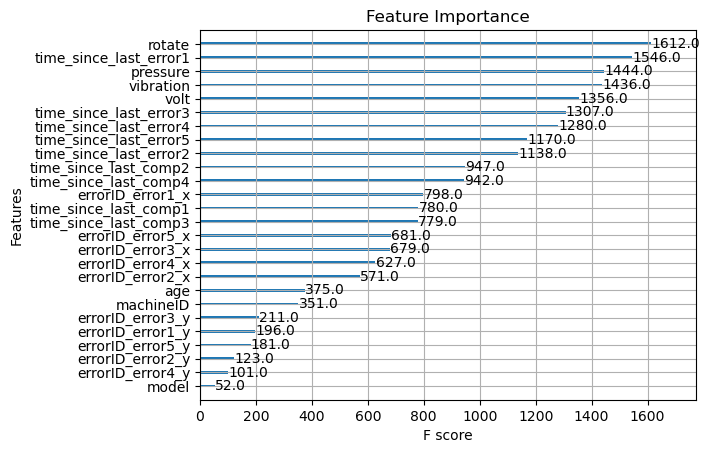

In [246]:
import matplotlib.pyplot as plt

# 特征重要性
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

epochs训练和验证误差

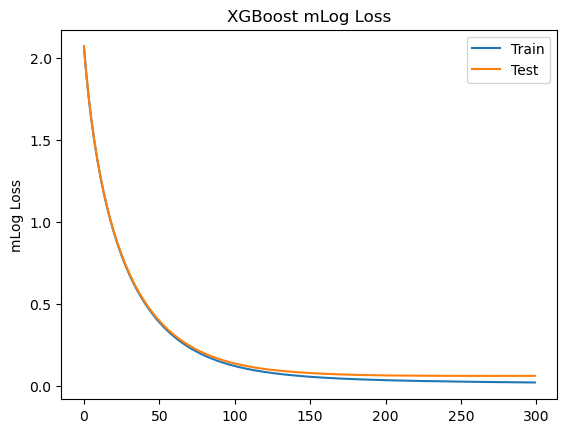

In [247]:
# 获取评估结果
evals_result = model.evals_result()

# 绘制训练和验证误差
epochs = len(evals_result['validation_0']['mlogloss'])
x_axis = range(0, epochs)
plt.plot(x_axis, evals_result['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['mlogloss'], label='Test')
plt.legend()
plt.ylabel('mLog Loss')
plt.title('XGBoost mLog Loss')
plt.show()

宏平均与微平均分数

In [248]:
from sklearn.metrics import f1_score

# 假设 y_test 是真实标签，y_pred 是模型预测结果
y_pred = model.predict(X_test)

# 计算微平均和宏平均的F1分数
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f'Macro-average F1: {f1_macro:.2f}')
print(f'Micro-average F1: {f1_micro:.2f}')

Macro-average F1: 0.89
Micro-average F1: 0.98


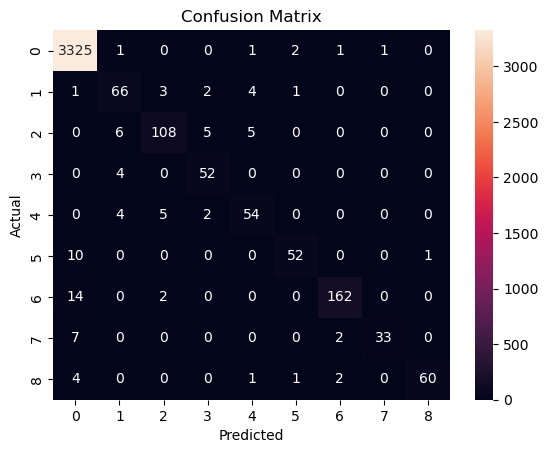

In [249]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 预测和真实标签（此处假设y_pred是模型预测结果，y_test是真实标签）
# y_pred = model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Light Boost

In [200]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# 转换数据格式
#train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

#-----------------过采样
train_smote = lgb.Dataset(X_train_smote, label=y_train_smote)
test_smote_data = lgb.Dataset(X_test, label=y_test, reference=train_smote)

# 设置参数
params = {
    'objective': 'multiclass',
    'num_class': num_class,  
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'max_depth': 4,
    'eta': 0.05,
    'n_estimators': 300,
    'bagging_fraction': 0.8,
    'bagging_freq': 3 
}

# 训练模型
modelLGB1 = lgb.train(params, train_data, valid_sets=[train_data, test_data])
modelLGB2 = lgb.train(params, train_smote, valid_sets=[train_smote, test_smote_data])

D:\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3537
[LightGBM] [Info] Number of data points in the train set: 9340, number of used features: 26
[LightGBM] [Info] Start training from score -0.181594
[LightGBM] [Info] Start training from score -3.819052
[LightGBM] [Info] Start training from score -3.585233
[LightGBM] [Info] Start training from score -4.266864
[LightGBM] [Info] Start training from score -3.910953
[LightGBM] [Info] Start training from score -4.092206
[LightGBM] [Info] Start training from score -3.175915
[LightGBM] [Info] Start training from score -4.478622
[LightGBM] [Info] Start training from score -4.379888
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

D:\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4781
[LightGBM] [Info] Number of data points in the train set: 9305, number of used features: 26
[LightGBM] [Info] Start training from score -0.685546
[LightGBM] [Info] Start training from score -2.771837
[LightGBM] [Info] Start training from score -2.498431
[LightGBM] [Info] Start training from score -3.179882
[LightGBM] [Info] Start training from score -2.846738
[LightGBM] [Info] Start training from score -3.029060
[LightGBM] [Info] Start training from score -2.053243
[LightGBM] [Info] Start training from score -3.366866
[LightGBM] [Info] Start training from score -3.203413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [201]:
from sklearn.metrics import mean_absolute_error
# 预测
y_pred1 = modelLGB1.predict(X_test)
y_pred1 = np.argmax(y_pred1, axis=1)  

# 评估
report1 = classification_report(y_test, y_pred1)
print(report1)

#------------------------------------------------------

# 预测
y_pred2 = modelLGB2.predict(X_test)
y_pred2 = np.argmax(y_pred2, axis=1)  

# 评估
report2 = classification_report(y_test, y_pred2)
print(report2)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3331
           1       0.83      0.87      0.85        77
           2       0.92      0.88      0.90       124
           3       0.85      0.91      0.88        56
           4       0.83      0.83      0.83        65
           5       0.93      0.81      0.86        63
           6       0.97      0.92      0.95       178
           7       0.94      0.74      0.83        42
           8       0.97      0.90      0.93        68

    accuracy                           0.98      4004
   macro avg       0.91      0.87      0.89      4004
weighted avg       0.98      0.98      0.98      4004

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3331
           1       0.86      0.91      0.89        77
           2       0.92      0.94      0.93       124
           3       0.89      0.89      0.89        56
           4       0.92 

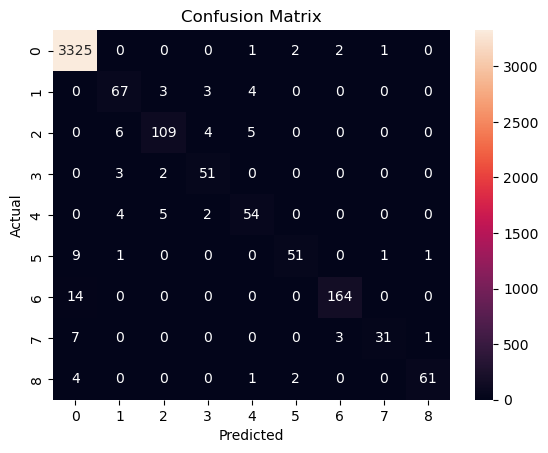

In [202]:
# 计算混淆矩阵
cm1 = confusion_matrix(y_test, y_pred1)

# 绘制混淆矩阵
sns.heatmap(cm1, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

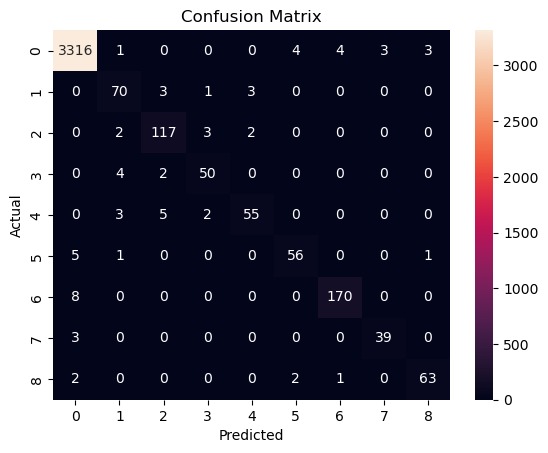

In [203]:
# 计算混淆矩阵
cm2 = confusion_matrix(y_test, y_pred2)

# 绘制混淆矩阵
sns.heatmap(cm2, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()